In [138]:
# start with importing the libraries we need
%matplotlib inline
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

In [139]:
# Define all the parameters
tau_m=10*b2.ms
v0=-50*b2.mV
eta=0*b2.mV
v_rest=15*b2.mV
R=50*b2.ohm
beta=10e5*b2.Hz

1. Consider N = 100 non-interacting neurons, with initial voltages $v_i(t = 0)$ uniformly distributed at random between $v_0$ and $η$ (i.e. $v_i(0) ∼ U([v_0,η])$), and submitted to an oscillating external input $I_{ext}(t) = I_0(1 + sin(ωt))$, with $I_0 = 0.5 mA$, $ω = 10^2 s^{−1}(= 0.1 ms^{−1})$. <br>
• Compute the membrane potentials $v_i(t)$ and firing times of the neurons, for $t ≤ T_f = 100 ms$. <br>
• Plot the voltage $v_i(t)$ of the first neuron, along with the external input $RI_{ext}(t)$.

In [140]:
def oscillating_current(Tf, timestep, I0 = 0.5*b2.mA, omega = 100*b2.Hz):
    n_time_steps = int(Tf / timestep) + 1
    current = I0 * (1 + np.sin(omega * range(n_time_steps)*timestep))
    return b2.TimedArray(current, dt=timestep)

In [141]:
def is_spike(v, timestep, eta = eta, beta = beta):
    return v >= eta and beta*timestep >= 0.5


def compute_potential(v_t0, I_ext : b2.TimedArray, Tf, timestep, v_rest = v_rest, v0 = v0, R = R, tau_m = tau_m):
    potentials = []
    spikes = []
    v = v_t0
    for k in range(int(Tf / timestep) + 1):
        v = v + timestep * (v_rest - v + R * I_ext(k*timestep)) / tau_m
        spikes.append(is_spike(v, timestep))
        if spikes[-1]:
            v = v0
        potentials.append(v)
    return b2.TimedArray(potentials, dt=timestep), b2.TimedArray(spikes, dt=timestep)

In [142]:
"""#current = oscillating_current(Tf, timestep)
a = b2.TimedArray([0,1,2,3,2], dt=0.1*b2.ms)
print(np.arange(0, len(a.values)*a.dt, a.dt))
np.arange(0, len(a.values))*a.dt*b2.second"""

'#current = oscillating_current(Tf, timestep)\na = b2.TimedArray([0,1,2,3,2], dt=0.1*b2.ms)\nprint(np.arange(0, len(a.values)*a.dt, a.dt))\nnp.arange(0, len(a.values))*a.dt*b2.second'

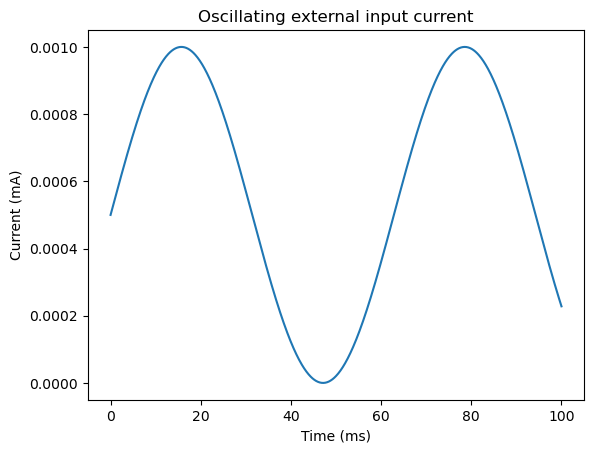

In [143]:
Tf = 100*b2.ms
timestep = 10e-2*b2.ms
I = oscillating_current(Tf, timestep)
plt.plot(np.arange(len(I.values))*I.dt/b2.ms, I.values)
plt.title('Oscillating external input current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (mA)')
plt.show()


In [144]:
# Define the current, the initial potential and other parameters
Tf=100*b2.ms
timestep=0.01*b2.ms
input_current = oscillating_current(Tf, timestep)
N=100
v_t0 = np.random.uniform(v0, eta, N) * b2.mV

In [145]:
# Compute the potentials and spikes
potentials, spikes = [], []
for neuron in range(N):
    p, s = compute_potential(v_t0[neuron], input_current, Tf, timestep)
    potentials.append(p)
    spikes.append(s)        

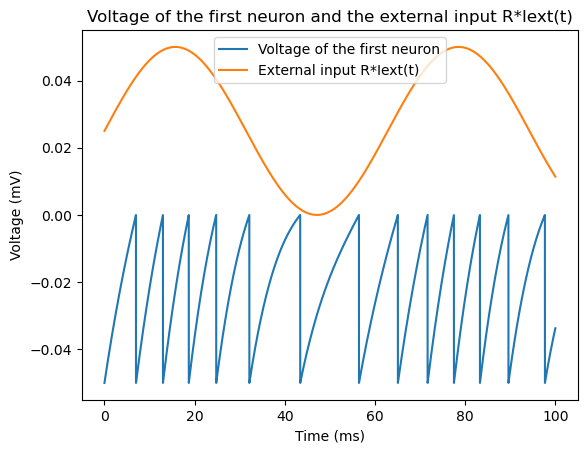

In [146]:
# Plot the voltage of the first neuron and the external input RIext(t)
plt.plot(np.arange(len(potentials[0].values))*potentials[0].dt/b2.ms, potentials[0].values, label='Voltage of the first neuron')
plt.plot(np.arange(len(input_current.values))*input_current.dt/b2.ms, R*input_current.values, label='External input R*Iext(t)')
plt.title('Voltage of the first neuron and the external input R*Iext(t)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()

2. Plot the low-pass filtered activity of the population, using a time bin of τA = 1ms. Make the corresponding raster plot

TypeError: object of type 'TimedArray' has no len()

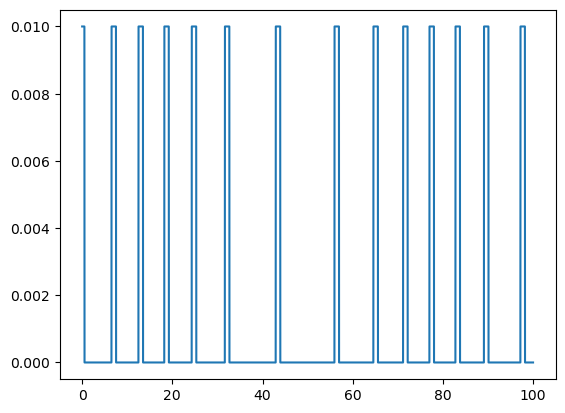

In [147]:
# Plot the low-pass filtered activity of the population, using a time bin of tau_A = 1ms
tau_A = 1*b2.ms
low_pass_filtered_activity = []
for neuron in range(N):
    low_pass_filtered_activity.append(np.convolve(spikes[neuron].values, np.ones(int(tau_A / timestep))/int(tau_A / timestep), mode='same'))

plt.plot(np.arange(len(low_pass_filtered_activity[0]))*timestep/b2.ms, low_pass_filtered_activity[0], label='Low-pass filtered activity of the first neuron')

# Make the corresponding raster plot
for neuron in range(N):
    plt.plot(np.arange(len(spikes[neuron]))*timestep/b2.ms, neuron*np.ones(len(spikes[neuron])), '|', color='black')  
plt.title('Low-pass filtered activity of the first neuron and the corresponding raster plot')
plt.xlabel('Time (ms)')
plt.ylabel('Low-pass filtered activity')
plt.legend()
plt.show()